# Writing a CNN for image classification

In [1]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist, cifar10, cifar100
import numpy as np
import matplotlib.pyplot as plot

print('Tensorflow version:',tensorflow.__version__)

Tensorflow version: 2.18.0


---

You can use the function below to load some of the simple datasets available directly from `keras`. There are three options for the `dataset_name` argument:
1. `mnist`: a dataset of handwritten digits from 0 - 9. These images are (28,28,1) in shape
2. `cifar10`: these are small colour images with shape (32,32,3) from ten different classes (plane, car, bird, cat, deer, dog, frog, horse, ship, truck)
3. `cifar100`: as above but with 100 classes! This will not be feasible to use with just a CPU as it would take a fairly complex network with many parameters. I have included it in case you want to play with this on a GPU one day

In [2]:
def load_dataset(dataset_name='mnist'):
  # MNIST, CIFAR10 and CIFAR100 are standard datasets we can load straight
  # from keras. The data are split between train and test sets automatically
  # - x_train is a numpy array that stores the training images
  # - y_train is a numpy array that stores the true class of the training images
  # - x_train is a numpy array that stores the testing images
  # - y_train is a numpy array that stores the true class of the testing images
  if dataset_name.lower() == 'cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    n_classes = 10
  elif dataset_name.lower() == 'cifar100':
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    n_classes = 100
  elif dataset_name.lower() == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # MNIST is greyscale so we have to do a trick to add a depth dimension
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    n_classes = 10
  else:
    print('Requested dataset does not exist. Please choose from mnist, cifar10 or cifar100')
    return

  # Let's check the shape of the images for convenience
  print("Shape of x_train =",x_train.shape)
  print("Shape of x_test =",x_test.shape)

  # The y_train and y_test values we loaded also need to be modified.
  # These values store the true classification of the images (0-9) as a single
  # number. We need to convert the single value into an array of length 10
  # corresponding to the number of output classes. Thus values of
  # y = 2 becomes y = [0,0,1,0,0,0,0,0,0,0]
  # y = 8 becomes y = [0,0,0,0,0,0,0,0,1,0]
  y_train = keras.utils.to_categorical(y_train, n_classes)
  y_test = keras.utils.to_categorical(y_test, n_classes)

  print("Shape of y_train =", y_train.shape)
  print("Shape of y_test =", y_test.shape)

  # Let's take a look at a few example images from the training set
  n_plots=5
  fig, ax = plot.subplots(1, n_plots)
  for plot_number in range (0, n_plots):
    ax[plot_number].imshow(x_train[plot_number])

  return (x_train, y_train), (x_test, y_test), n_classes

---

Here we use the `load_data` function to load our dataset. In the
first instance we will use `mnist` since it is the simplest dataset and we can use a very simple CNN.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape of x_train = (50000, 32, 32, 3)
Shape of x_test = (10000, 32, 32, 3)
Shape of y_train = (50000, 10)
Shape of y_test = (10000, 10)


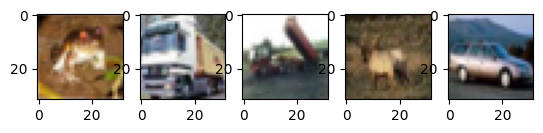

In [23]:
# Load the input data.
# x_train is the training data, and y_train the corresponding true labels
# x_test is the testing data, and y_test the corresponding true labels
# We don't have a separate validation sample in these keras datasets
# Num_classes is the number of true classes
(x_train, y_train), (x_test, y_test), num_classes = load_dataset('cifar10')

Before starting our CNN, let's make a simple MLP to see how well it does. MLPs consist of a number of fully connected (or dense) layers. We need to make sure that we flatten the input in this case since we have images. We'll make a network with three dense layers (256, 128 and 64 neurons) interspersed with dropout layers (fraction 0.25), and then the final dense layer for classification.

* Flatten layer: `keras.layers.Flatten()`

* Dense layer: `keras.layers.Dense(num_nodes, activation='relu')` where the num_nodes is how many neurons are in the layer. The final layer of the model needs have to have `num_nodes = num_classes`, and should use the `softmax` activation

* Dropout layer: `keras.layers.Dropout(fraction)`

Printing a summary of the network should give you the following:
```Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 242,762 (948.29 KB)
 Trainable params: 242,762 (948.29 KB)
 Non-trainable params: 0 (0.00 B)


In [24]:
# Define our MLP: replace "None" with the corresponding layers as described
input_layer = keras.layers.Input(x_train[0].shape)
# First layer: flatten the 2D input into 1D for the dense layers
x = keras.layers.Flatten()(input_layer)
# Second layer: dense layer with 256 neurons and a relu activation
x = keras.layers.Dense(256, activation='relu')(x)
# Third layer: dropout with 25% of neurons disabled
x = keras.layers.Dropout(0.25)(x)
# Fourth layer: dense layer with 128 neurons and a relu activation
x = keras.layers.Dense(128, activation='relu')(x)
# Fifth layer: dropout with 25% of neurons disabled
x = keras.layers.Dropout(0.25)(x)
# Sixth layer: dense layer with 64 neurons and a relu activation
x = keras.layers.Dense(64, activation='relu')(x)
# Seventh layer: dropout with 25% of neurons disabled
x = keras.layers.Dropout(0.25)(x)
# Eighth layer: dense layer for classification into the number of classes
x = keras.layers.Dense(num_classes, activation='softmax')(x)
# Define the model from the input and final layers
mlp_model = keras.Model(input_layer, x)
# Print the model summary
mlp_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         786,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 828,490 (3.16 MB)

 Trainable params: 828,490 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

Now we need to define the loss function and optimiser that we will use to perform the gradient descent optimisation.

* `keras.losses.categorical_crossentropy` is the loss function for multi-category classification tasks
* `keras.optimizers.Adam(learning_rate=<learning_rate>)` is a choice of optimiser that can be used here. We need to give the learning rate as an argument

The next step is to then compile the model and tell it which loss function and optimiser to use, and which metrics to display whilst training.

* `model.compile(loss=<loss_function>, optimizer=<optimiser>, metrics=['accuracy'])`, to give an example where we will see the accuracy during the training process.

In [25]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 5
# The learning rate (step size in gradient descent)
learning_rate = 0.001
# Define the loss function and optimiser and then compile the model, replacing
# "None" as required
# Categorical crossentropy loss function
loss_function = keras.losses.categorical_crossentropy
# Adam optimiser using the learning rate defined above
optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
# Compile the model with the loss function and optimisers defined above
mlp_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

Now we are ready to train our MLP and run it on the MNIST dataset. We do this using the `fit` function of the model. It has many arguments, of which I list those we will need below:

* `model.fit(x=<x>, y=<y>, batch_size=<batch_size>, epochs=<epochs>, validation_data = (<x_test>, <y_test>), verbose=1)`

In [26]:
# Train the model using the training images and targets, and use the test
# images as the validation sample. Replace "None" as appropriate
mlp_model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data = (x_test, y_test), verbose=1)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0987 - loss: 35.9019 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0990 - loss: 2.3029 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.0980 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1038 - loss: 2.3026 - val_accuracy: 0.0999 - val_loss: 2.3028
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0982 - loss: 2.3026 - val_accuracy: 0.0999 - val_loss: 2.3029


Let's define a couple of functions to look at some images that we classified incorrectly

In [27]:
# Make a list of incorrect classifications
def FindIncorrectClassifications(network_model, images, targets):
    incorrect_indices = []
    # Use the network to predict the classification of the images.
    raw_predictions = network_model.predict(images)
    for i in range(0, len(raw_predictions)):
        # Remember the raw output from the CNN gives us an array of scores. We want
        # to select the highest one as our prediction. We need to do the same thing
        # for the truth too since we converted our numbers to a categorical
        # representation earlier. We use the np.argmax() function for this
        prediction = np.argmax(raw_predictions[i])
        truth = np.argmax(targets[i])
        if prediction != truth:
            incorrect_indices.append([i,prediction,truth])
    print('Number of images that were incorrectly classified =',len(incorrect_indices))
    return incorrect_indices

def DrawFailure(images, incorrect_indices, index_to_show=0):
    image_to_plot = images[incorrect_indices[index_to_show][0]]
    fig, ax = plot.subplots(1, 1)
    print('Incorrect classification for image',incorrect_indices[index_to_show][0],
          ': predicted =',incorrect_indices[index_to_show][1],
          'with true =',incorrect_indices[index_to_show][2])
    ax.imshow(image_to_plot)

And now lets look at the images

In [28]:
mlp_failures = FindIncorrectClassifications(mlp_model, x_test, y_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Number of images that were incorrectly classified = 9001


Incorrect classification for image 3 : predicted = 4 with true = 0


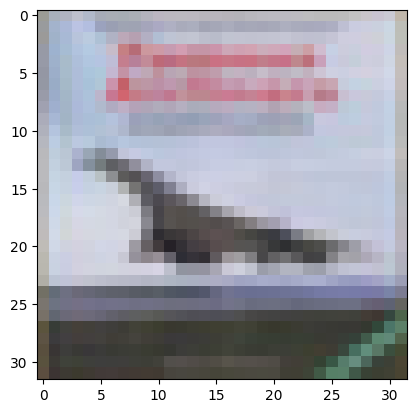

In [29]:
DrawFailure(x_test, mlp_failures, 3)

---

Now we want to define a CNN. The basic building blocks you will need are:


*   Convolutional layers: `keras.layers.Conv2D(num_filters, (k,k), activation='relu')`. Typical values of `k` are 3, 5, or 7
*   Pooling layers: `keras.layers.MaxPooling2D((2,2))` will perform a factor of 2 downsampling in the two dimensions of image
*   Dropout: keras.layers.Dropout(fraction) where fraction is the fraction of weights that are ignored. Typical values can be 0.25 or 0.5
*   Dense layers: `keras.layers.Dense(num_nodes, activation='relu')` where the num_nodes is how many neurons are in the layer. The final layer of the CNN needs have to have `num_nodes = num_classes`
*   Flatten layer: This just converts and n-dimensional tensor into a vector. In this case we use it to present a dense output layer with a vector input


In the following way of writing our network, we need to write things in the form:

`layer_output = keras.layers.LayerNameHere(arguments_go_here)(layer_input)`

For the first CNN we are building, you will hopefully see the following output from the model.summary() command:

```
Model: "model"
_________________________________________________________________
 Layer (type)                 Output Shape              Param #   
=================================================================
 input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
                                                              
 dropout (Dropout)            (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)            (None, 5408)              0         
                                                                 
 dense (Dense)                (None, 10)                54090     
                                                                 
=================================================================
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
```

In [30]:
# Define our simple CNN model: replace "None" with the corresponding layers as described
input_layer = keras.layers.Input(x_train[0].shape)
# First layer: 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer)
# Second layer: 2D max pooling layer to downsample by a factor of 2 in both dimensions
x = keras.layers.MaxPooling2D((2,2))(x)
# Third layer: dropout with 25% of neurons disabled
x = keras.layers.Dropout(0.25)(x)
# Fourth layer: flatten the output into 1D for input to a dense layer
x = keras.layers.Flatten()(x)
# Fifth layer: dense layer for classification into the number of classes
x = keras.layers.Dense(num_classes, activation='softmax')(x)
# Define the model from the input and final layers
cnn_model = keras.Model(input_layer, x)
# Print the model summary
cnn_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │          72,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,906 (284.79 KB)

 Trainable params: 72,906 (284.79 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Set up the model to train with the same hyperparameters as the MLP
cnn_loss_function = keras.losses.categorical_crossentropy
cnn_optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
cnn_model.compile(loss=cnn_loss_function, optimizer=cnn_optimiser, metrics=['accuracy'])

Now we can run our network on whichever data sample we requested. Initially on `mnist` we'll hopefully see that we can reach a very high accuracy.

In [32]:
# Train the model using the training images and targets, and use the test
# images as the validation sample.
cnn_model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test))


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.1816 - loss: 20.3168 - val_accuracy: 0.2902 - val_loss: 2.0681
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.3241 - loss: 2.0018 - val_accuracy: 0.3743 - val_loss: 1.8404
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.3963 - loss: 1.7610 - val_accuracy: 0.4285 - val_loss: 1.6761
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4281 - loss: 1.6585 - val_accuracy: 0.4361 - val_loss: 1.6695
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.4548 - loss: 1.5818 - val_accuracy: 0.4595 - val_loss: 1.5844


Now let's look at some failures again

In [33]:
cnn_failures = FindIncorrectClassifications(cnn_model, x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Number of images that were incorrectly classified = 5405


Incorrect classification for image 15 : predicted = 2 with true = 8


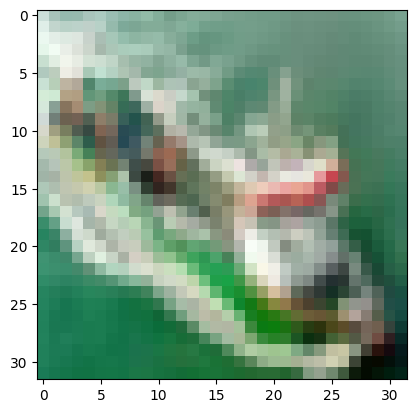

In [35]:
DrawFailure(x_test, cnn_failures, 5)

Now feel free to go back and change the dataset to the `cifar10` one, and try running the MLP and CNN again. What do you notice?